In [1]:
import fastf1 as ff1
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
ff1.Cache.enable_cache('../cache')
pd.options.mode.chained_assignment = None

In [2]:
fp = ff1.get_event(2024, 1)

In [3]:
p1 = fp.get_practice(1)
p1.load()

p2 = fp.get_practice(2)
p2.load()

p3 = fp.get_practice(3)
p3.load()

core           INFO 	Loading data for Bahrain Grand Prix - Practice 1 [v3.3.0]
req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
req            INFO 	Data has been written to cache!
req            INFO 	Updating cache for driver_info...
_api           INFO 	Fetching driver list...
req            INFO 	Cache updated!
core        WARNING 	No result data for this session available on Ergast! (This is expected for recent sessions)
req            INFO 	Updating cache for session_status_data...
_api           INFO 	Fetching session status data...
req            INFO 	Cache updated!
req            INFO 	Updating cache for track_status_data...
_api           INFO 	Fetching track status data...
req            INFO 	Cache updated!
req            INFO 	No cached data found for _extended_timing_data. Loading data...
_api           INFO 	Fetching timing data...
_api           INFO 	Parsing timing data...
req            INF

In [39]:
def compound_color(compound):
    match compound:
        case 'HARD' : return 'lightgrey'
        case 'MEDIUM' : return 'gold'
        case 'SOFT' : return 'red'

def day_marker(day):
    match day:
        case 1 : return 'o:'
        case 2 : return 'D:'
        case 3 : return 's:'

# Pick out stints of a session
def pick_stints(laps, min_len = 5, quicklaps_threshold = 1.10):
    laps = laps.pick_quicklaps(quicklaps_threshold)
    laps.set_index('LapNumber', inplace=True)
    laps['LapTime'] = [t.total_seconds() for t in laps['LapTime']]
    stints = [x for _, x in laps.groupby(['Stint', 'Driver'])]
    stints = [stint for stint in stints if len(stint) > min_len]
    return stints

from fastf1 import plotting
plt.style.use('dark_background')
def compare_long_runs_deg(day_laps, title, comparison_teams, main_team = 'Alpine', remove_outlier=False, min_laps = 5):
    laps = day_laps
    laps['Color'] = laps['Compound'].apply(compound_color)

    laps = laps.pick_team(main_team)

    stints_1 = pick_stints(laps, min_len= min_laps)

    # remove some eye picked outliers. Gasly's stint is not a long stint but multiple quick laps
    if remove_outlier:
        stints_1 = stints_1[1:]

    plt.figure(figsize=(15, 10))
    plt.title(title)
    ax = plt.subplot()
    ax.grid(zorder=10, alpha=0.2)
    ax.set_xlabel('Laps')
    ax.set_ylabel('Lap time (s)')
    #ax.set_ylim(bottom=94, top=101)
    ax.set_xticks(range(0, 25, 5))

    main_team_label = main_team
    marker = day_marker(1)

    # plot day 1
    for stint in stints_1:
        s = stint.reset_index()
        ax.plot(s.index + 1, s['LapTime'], marker, color = plotting.team_color(main_team), label = main_team_label)
        main_team_label = None

    for team_name in comparison_teams:
        if team_name == main_team:
            continue
        baseline = pick_stints(day_laps.pick_team(team_name), min_len=min_laps)[:1]
        for stint in baseline:
            s = stint.reset_index()
            ax.plot(s.index + 1, s['LapTime'], marker, color=plotting.team_color(team_name), label = team_name)

    plt.legend()
    plt.show()

comparison_teams = sorted(p1.results['TeamName'].unique())

In [205]:
p3.laps.pick_team('Alpine')['Compound'].value_counts()

Compound
SOFT    25
Name: count, dtype: int64

/var/folders/q1/q9_ky6lj68g7kv_5x5_pd9jw0000gp/T/ipykernel_84253/86835457.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ocon_laps['LapTime'] = [t.total_seconds() for t in ocon_laps['LapTime']]


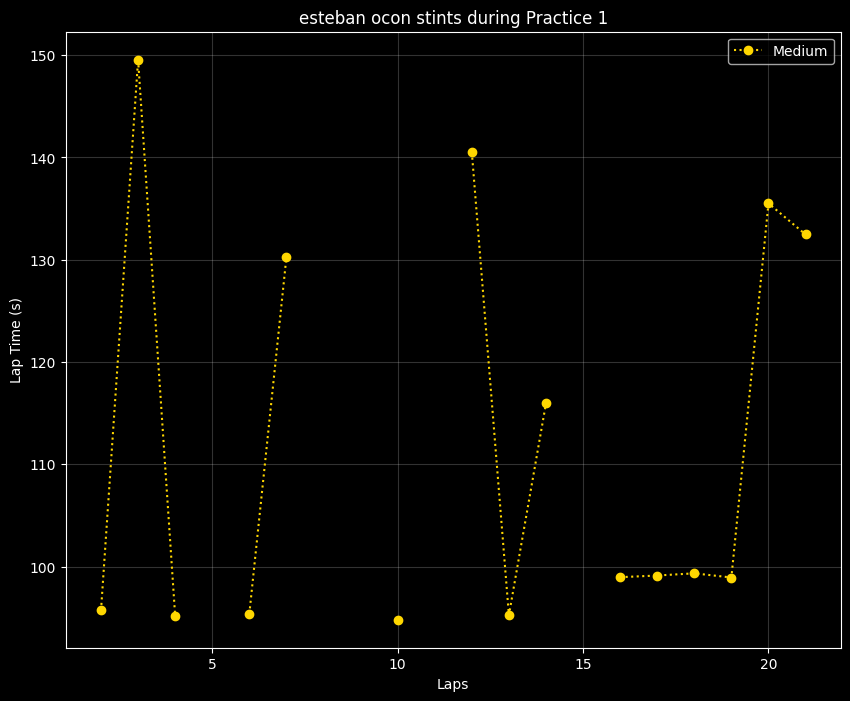

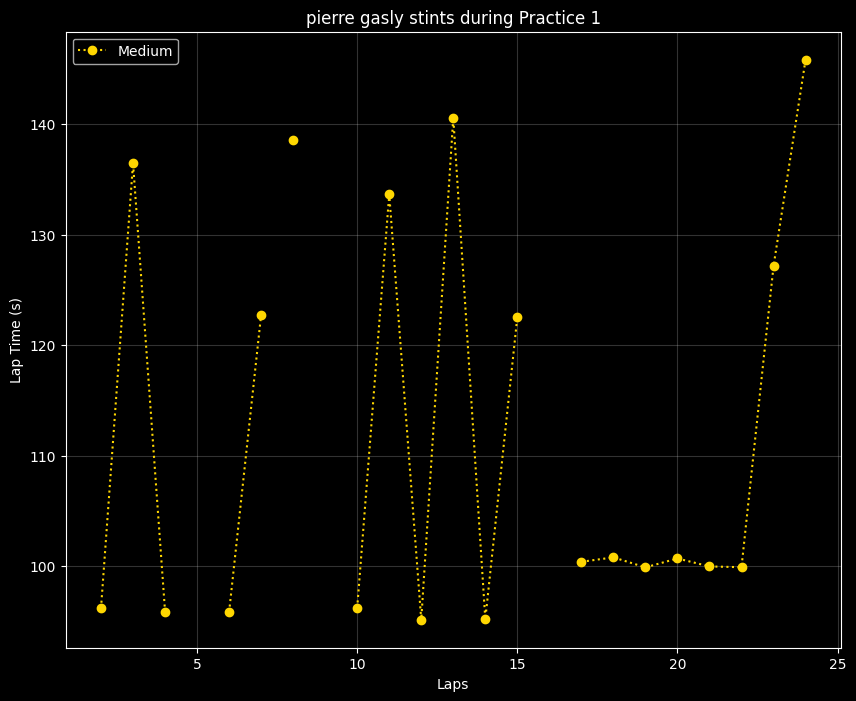

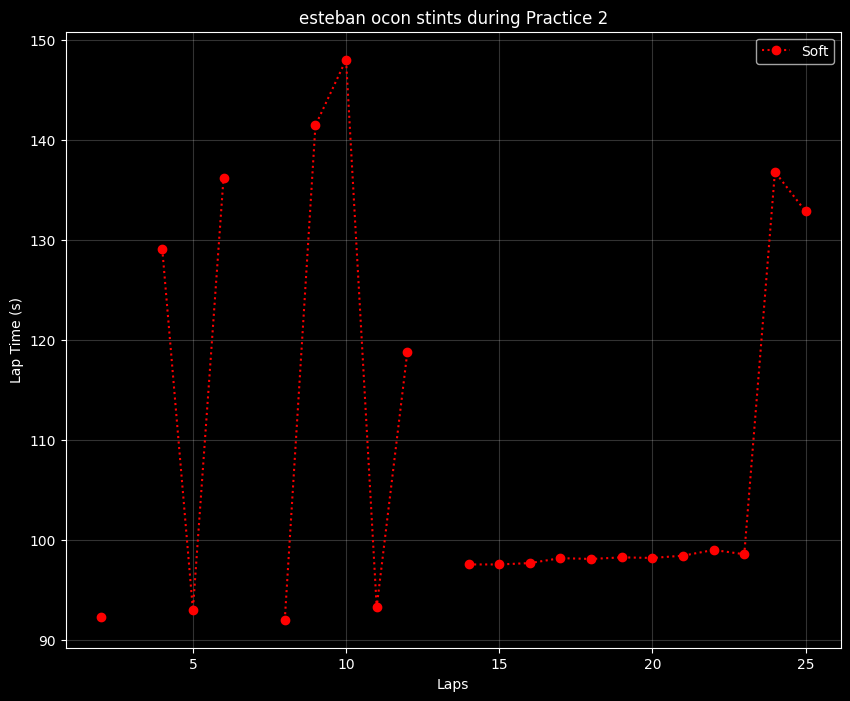

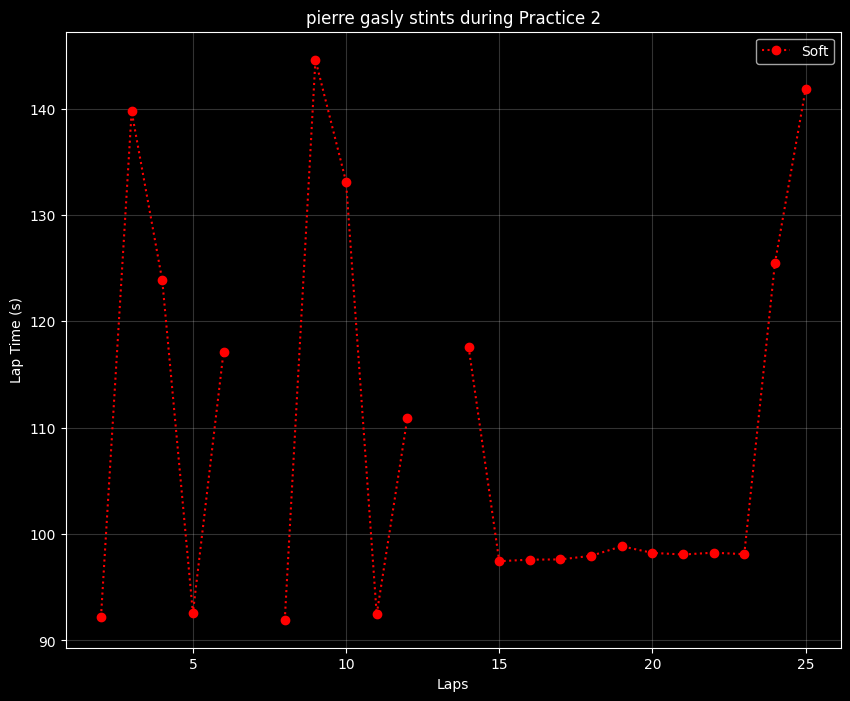

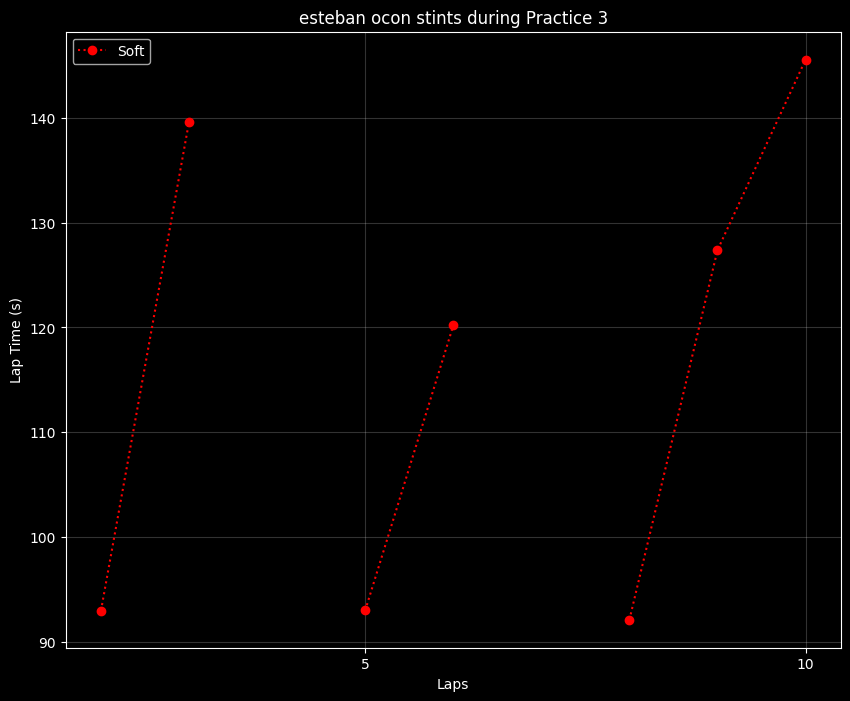

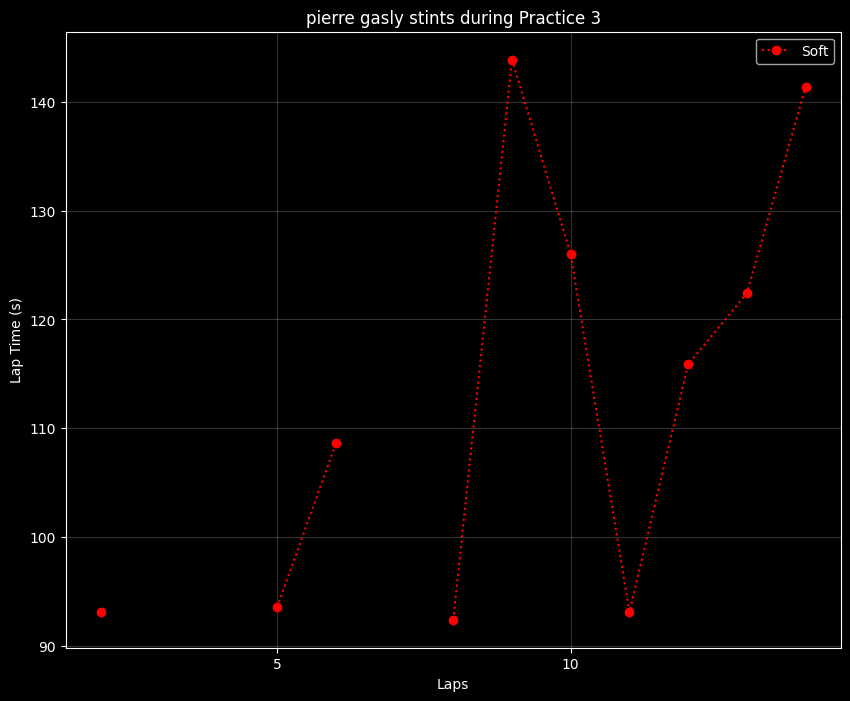

In [27]:
def plot_testing(session, driver, limit=1.30):
    #laps = session.laps.pick_quicklaps(limit)
    laps = session.laps

    ocon_laps = laps[laps['Driver'] == driver]
    ocon_laps.set_index('LapNumber', inplace=True)
    ocon_laps['LapTime'] = [t.total_seconds() for t in ocon_laps['LapTime']]

    ocon_stints = [x for _, x in ocon_laps.groupby('Stint')]
    plt.figure(figsize=(10,8))
    ax = plt.subplot()

    max_lap = int(max([s.index.max() for s in ocon_stints]))
    ax.set_xticks(range(0, max_lap + 5, 5))
    c1_label = False
    c2_label = False
    c3_label = False
    for stint in ocon_stints:
        label = 'Hard' if stint['Compound'].iloc[0] == 'HARD' else 'Medium' if stint['Compound'].iloc[0] == 'MEDIUM' else 'Soft'
        match label:
            case 'Hard':
                if c1_label == False:
                    c1_label = True
                else:
                    label = None
            case 'Medium':
                if c2_label == False:
                    c2_label = True
                else:
                    label = None
            case 'Soft':
                if c3_label == False:
                    c3_label = True
                else:
                    label = None
        ax.plot(stint['LapTime'], 'o:', color=compound_color(stint['Compound'].iloc[0]), label=label)
    ax.grid(alpha=0.2)
    ax.set_xlabel('Laps')
    ax.set_ylabel('Lap Time (s)')
    plt.title(label = plotting.DRIVER_TRANSLATE[driver] + ' stints during ' + session.name)
    plt.legend()
    plt.show()

plot_testing(p1, 'OCO')
plot_testing(p1, 'GAS')

plot_testing(p2, 'OCO')
plot_testing(p2, 'GAS')

plot_testing(p3, 'OCO')
plot_testing(p3, 'GAS')

In [6]:
p1.laps.groupby(['Driver', 'Stint'])

In [229]:
limit = 1.15
p1_quick = p1.laps.pick_quicklaps(limit)
p1_quick['Session'] = 1
p2_quick = p2.laps.pick_quicklaps(limit)
p2_quick['Session'] = 2
p3_quick = p3.laps.pick_quicklaps(limit)
p3_quick['Session'] = 3
fp_laps = pd.concat([p1_quick, p2_quick, p3_quick])

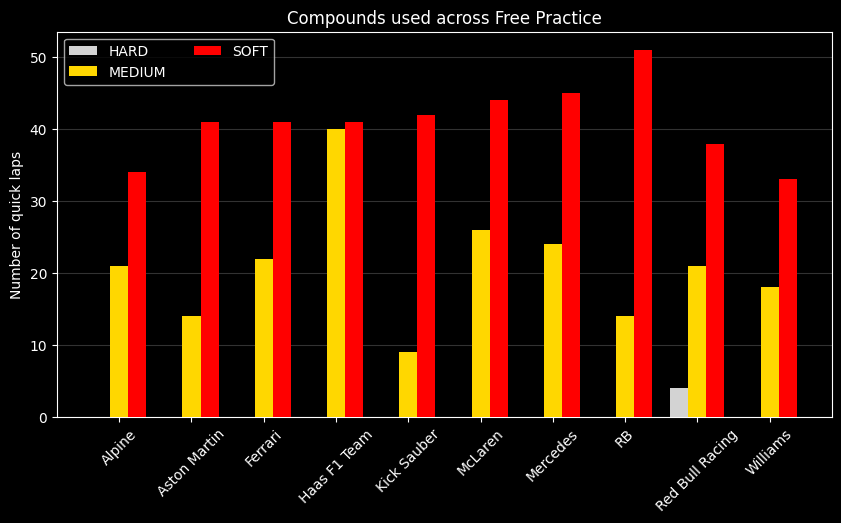

In [232]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming fp_laps is your DataFrame and compound_color is a function that returns colors

# Step 1: Convert the groupby size result to a DataFrame with teams as columns and compounds as rows
compounds_used_df = fp_laps.groupby(['Compound', 'Team']).size().unstack(fill_value=0)

# Make sure teams and compounds are sorted if needed
teams = sorted(compounds_used_df.columns)
compounds = sorted(compounds_used_df.index)

fig = plt.figure(figsize=(10, 5))
ax = plt.subplot()

x = np.arange(len(teams))
width = 0.25
pos = 0

# Iterate over compounds and plot bars for each team
for compound in compounds:
    # Here, we explicitly specify the height of each bar per team for the compound
    heights = [compounds_used_df.loc[compound, team] if compound in compounds_used_df.index and team in compounds_used_df.columns else 0 for team in teams]
    rects = ax.bar(x + width * pos, heights, width=width, label=compound, color=compound_color(compound), zorder=3)
    pos += 1

# Correct the way x-ticks are set
ax.set_xticks(x + width * (len(compounds) / 2 - 0.5))  # Adjust this to align ticks correctly
ax.set_xticklabels(teams, rotation=45)

ax.legend(loc='upper left', ncols=2)
ax.grid(zorder=0, axis='y', alpha=0.2)
plt.title('Compounds used across Free Practice')
plt.ylabel('Number of quick laps')
plt.show()


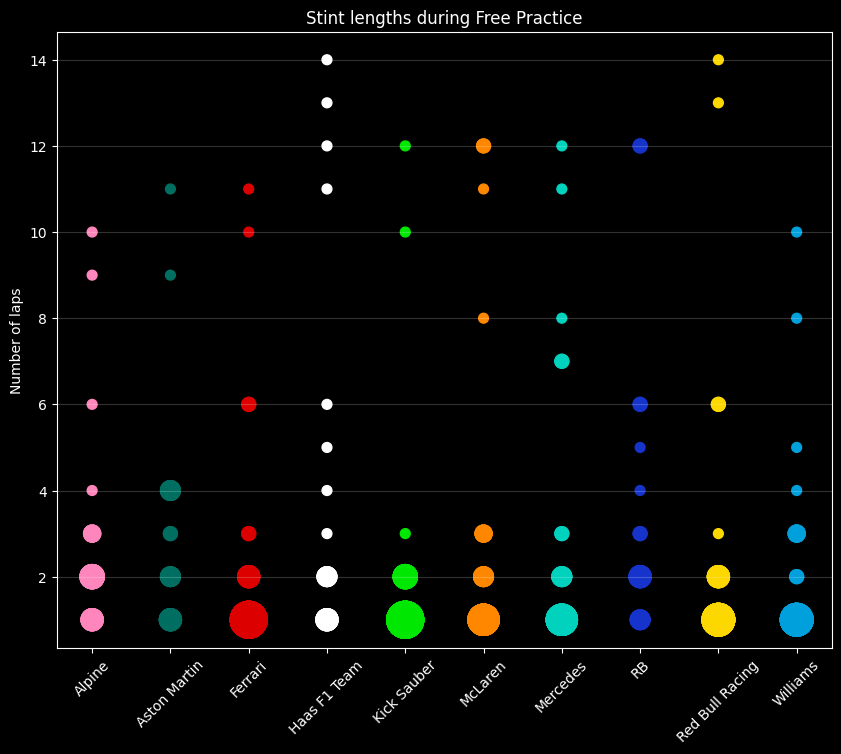

In [239]:
stint_length = pd.DataFrame(
    [(team, len(laps)) for (driver, team, stint, session), laps in fp_laps.groupby(['Driver', 'Team', 'Stint', 'Session'])],
    columns = ['Team', 'StintLength']
)

occurrences = stint_length.groupby(['Team', 'StintLength']).size().reset_index(name='Occurrences')
p1_stint_length = stint_length.merge(occurrences, how='left', on=['Team', 'StintLength'])

plt.figure(figsize=(10,8))
plt.xticks(rotation=45)
ax = plt.subplot()
ax.grid(axis='y', alpha=0.2, zorder=2)
for team, stint_len in p1_stint_length.groupby('Team'):
    ax.scatter(stint_len['Team'], stint_len['StintLength'], s=stint_len['Occurrences']*50, c=ff1.plotting.team_color(team.lower()))

plt.title('Stint lengths during Free Practice')
plt.ylabel('Number of laps')
plt.show()

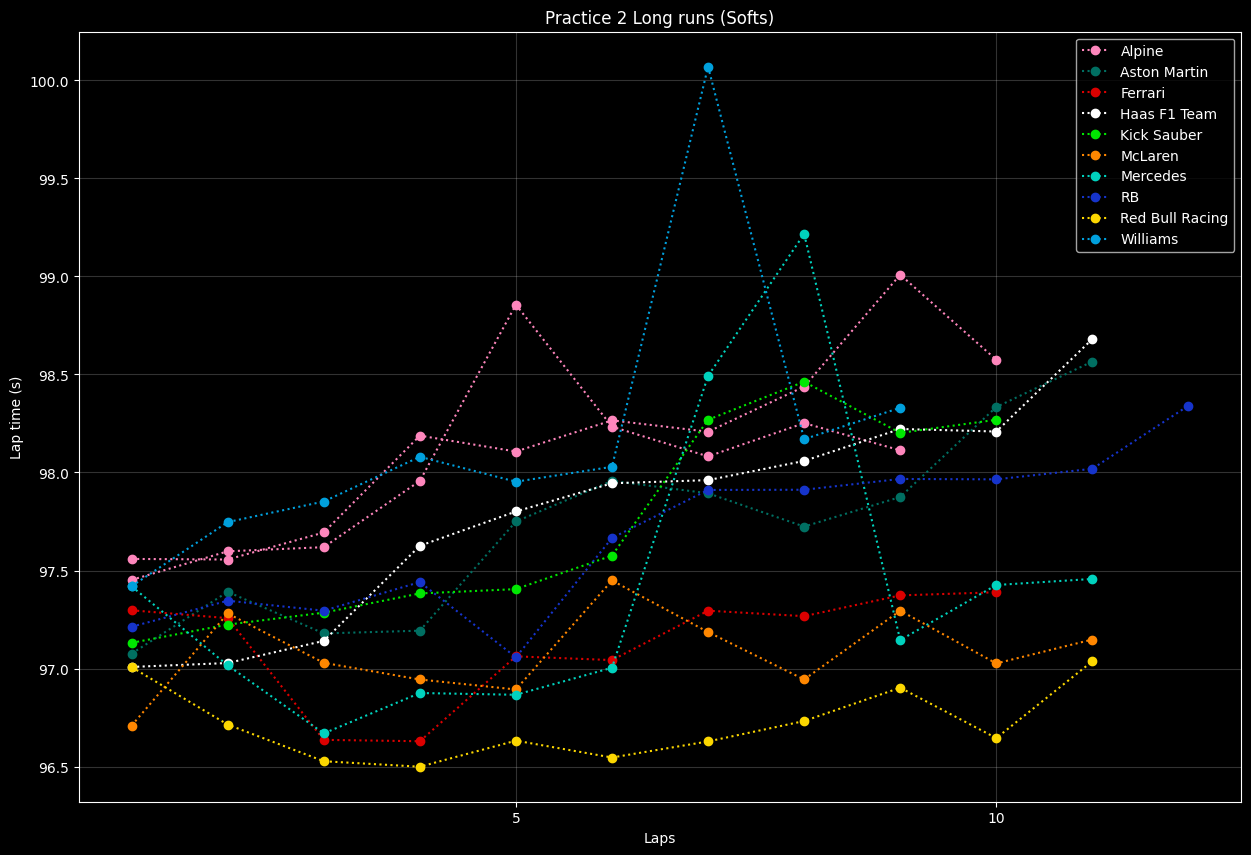

In [34]:
compare_long_runs_deg(p2.laps[p2.laps['Compound'] == 'SOFT'], 'Practice 2 Long runs (Softs)', comparison_teams, remove_outlier=False)

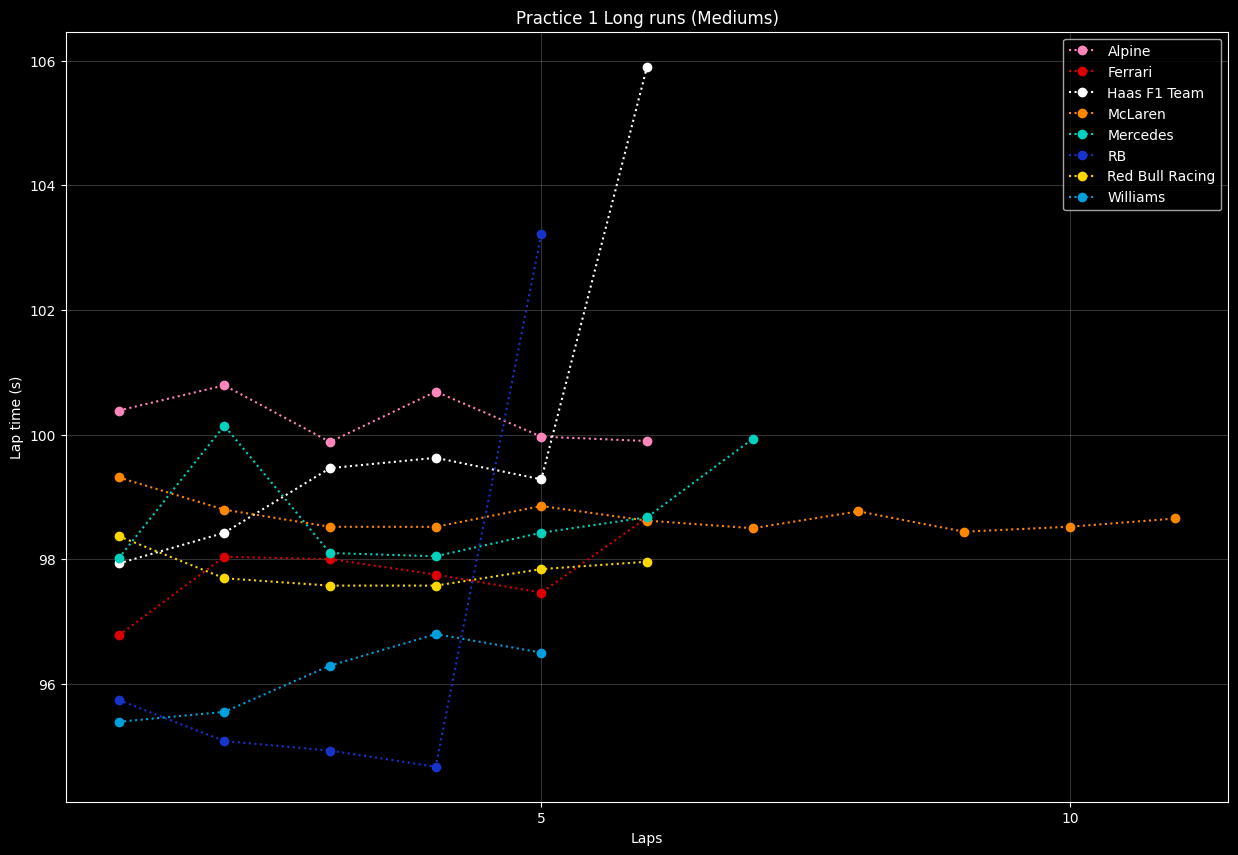

In [40]:
compare_long_runs_deg(p1.laps[p1.laps['Compound'] == 'MEDIUM'], 'Practice 1 Long runs (Mediums)', comparison_teams, min_laps=4)

/var/folders/q1/q9_ky6lj68g7kv_5x5_pd9jw0000gp/T/ipykernel_84253/934759593.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  laps['Color'] = laps['Compound'].apply(compound_color)
/var/folders/q1/q9_ky6lj68g7kv_5x5_pd9jw0000gp/T/ipykernel_84253/934759593.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  laps['LapTime'] = [t.total_seconds() for t in laps['LapTime']]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called

[]


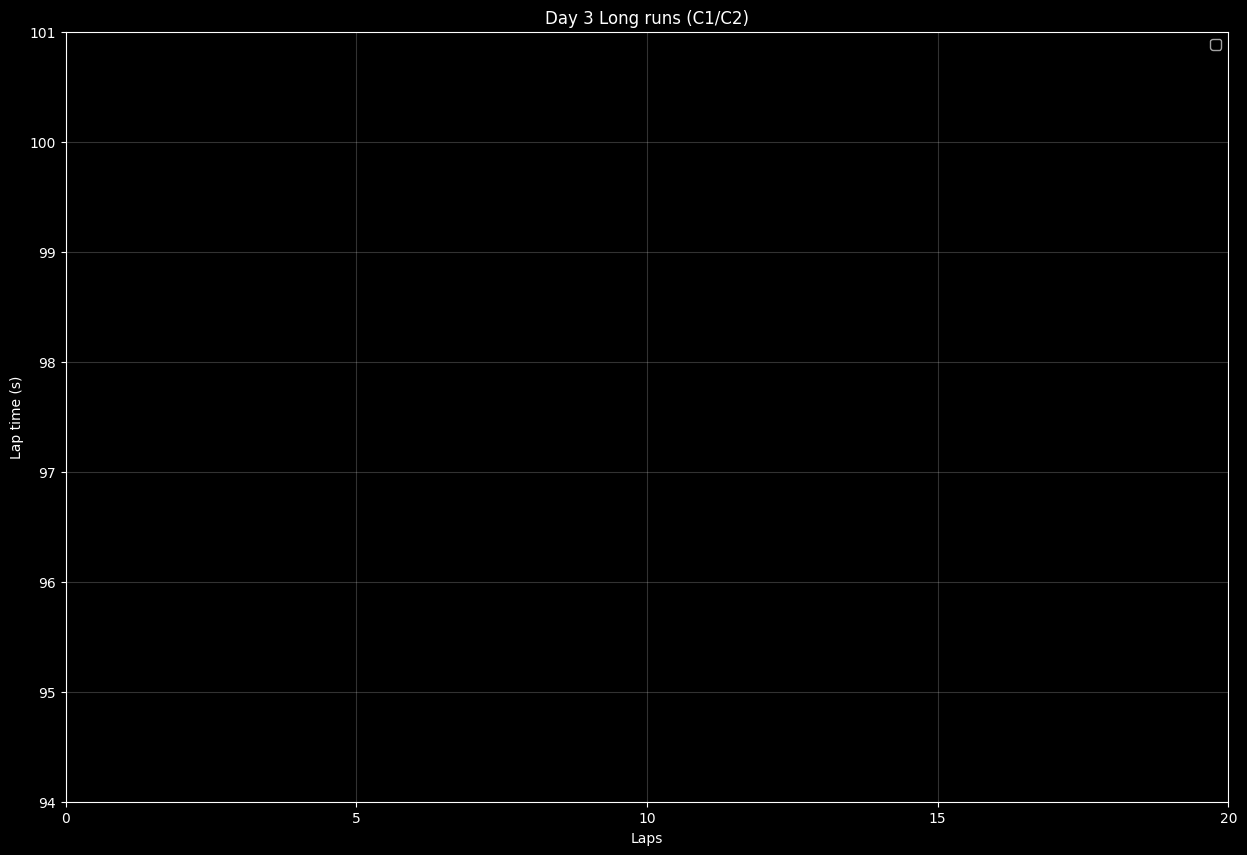

/var/folders/q1/q9_ky6lj68g7kv_5x5_pd9jw0000gp/T/ipykernel_84253/934759593.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  laps['Color'] = laps['Compound'].apply(compound_color)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[]


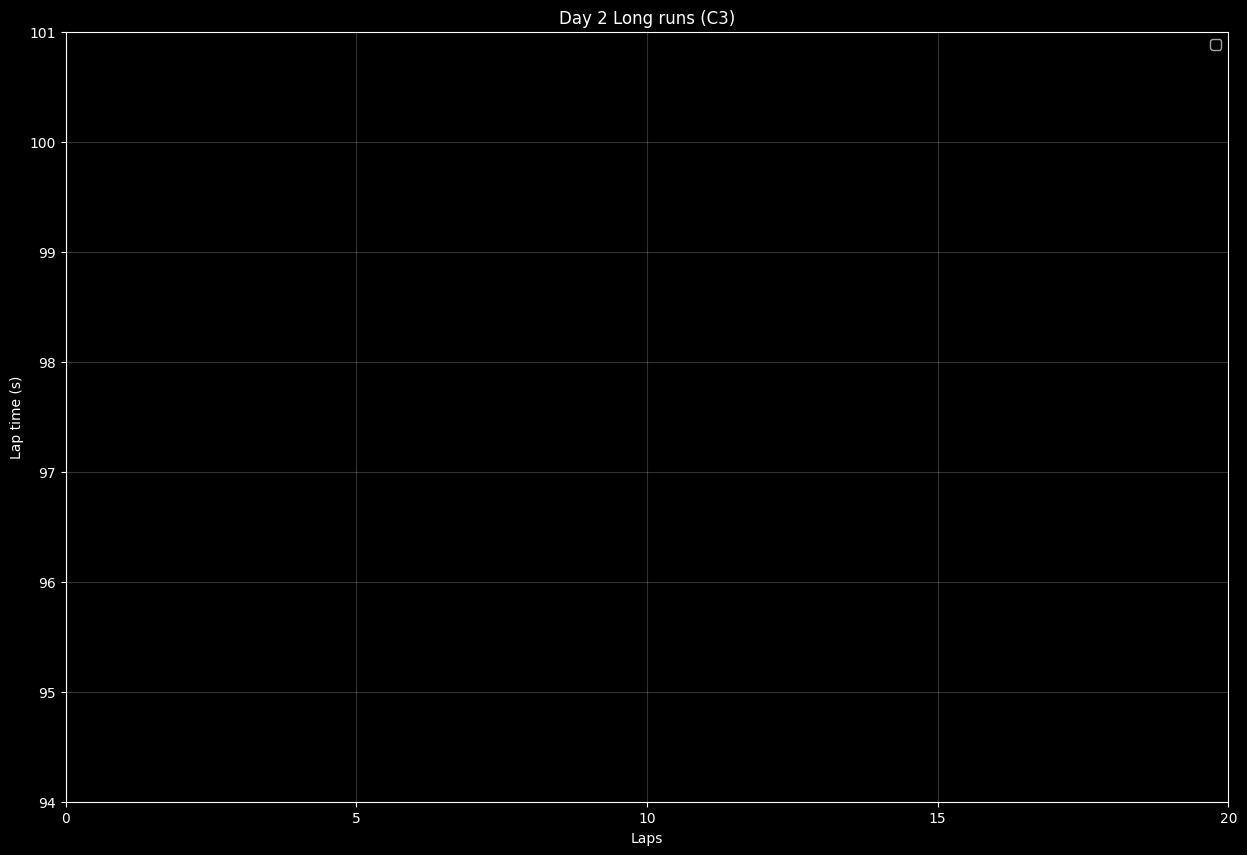

/var/folders/q1/q9_ky6lj68g7kv_5x5_pd9jw0000gp/T/ipykernel_84253/934759593.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  laps['Color'] = laps['Compound'].apply(compound_color)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[]


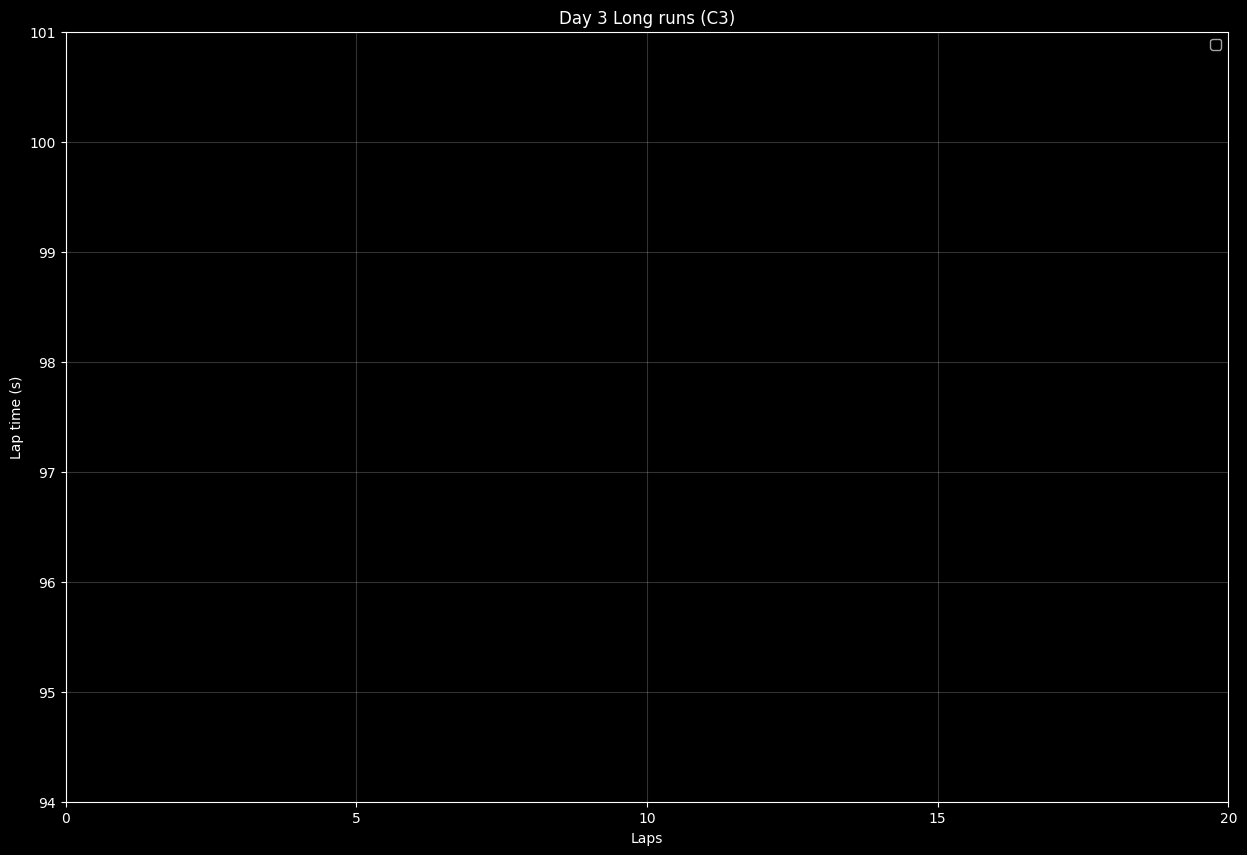

In [21]:


compare_long_runs_deg(p3.laps[p3.laps['Compound'] == 'HARD'], 'Day 3 Long runs (C1/C2)', comparison_teams, remove_outlier=True)
compare_long_runs_deg(p2.laps[p2.laps['Compound'] == 'MEDIUM'], 'Day 2 Long runs (C3)', comparison_teams, remove_outlier=True)
compare_long_runs_deg(p3.laps[p3.laps['Compound'] == 'MEDIUM'], 'Day 3 Long runs (C3)', comparison_teams, remove_outlier=True)
